[Source](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb)

In [59]:
import matplotlib.pyplot as plt
import os, pdb
import numpy as np
from PIL import Image
import pandas as pd

import torch.nn.functional as F
from typing import Tuple
from torch.nn import MSELoss
from transformers import SamModel 
from transformers import SamProcessor
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from torch.optim import Adam
import monai

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from datasets import load_dataset


     

In [50]:
DATA_DIR = '/sddata/data/MedSAM/public_test_data_01_10_2023'

In [ ]:
dataset = load_dataset("nielsr/breast-cancer", split="train")

In [28]:

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 130
})

In [58]:

example = dataset[0]
image = example["image"]
type(image)

PIL.PngImagePlugin.PngImageFile

In [42]:
label = example['label']
label = np.array(label) * 255
label

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [43]:
label.shape

(256, 256)

In [40]:
np.array(label)[60:180,30:90]

array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)

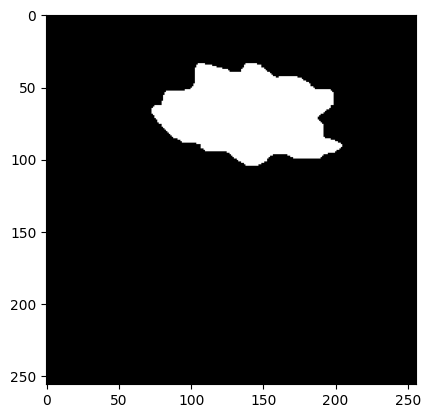

In [45]:
plt.imshow(label, cmap='gray')

256 256


(-0.5, 255.5, 255.5, -0.5)

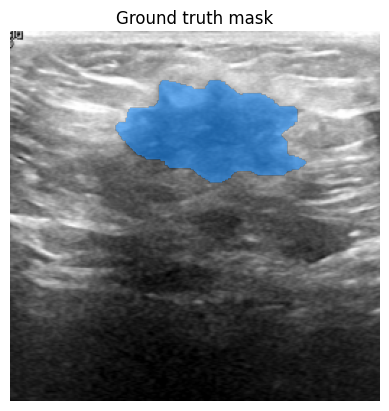

In [31]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        # color = np.array([30/255, 144/255, 255/255, 0.6])
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    print(h, w)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
ground_truth_seg = np.array(example["label"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

## Create Pytorch Dataset

Below we define a regular PyTorch dataset, which gives us examples of the data prepared in the format for the model. Each example consists of:

* pixel values (which is the image prepared for the model)
* a prompt in the form of a bounding box
* a ground truth segmentation mask.
The function below defines how to get a bounding box prompt based on the ground truth segmentation. This was taken from here.

Note that SAM is always trained using certain "prompts", which you could be bounding boxes, points, text, or rudimentary masks. The model is then trained to output the appropriate mask given the image + prompt.

In [ ]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [ ]:
class SAMDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        ground_truth_mask = np.array(item["label"])

        # get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)

        # prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

In [ ]:
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [ ]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [ ]:
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

## Create PyTorch DataLoader

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)

## Load the model


In [ ]:
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

In [ ]:
model

## Train the model

In [ ]:
# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
num_epochs = 5

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)
        
        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
        
        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()
        
        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

### Save it

In [ ]:
# Save the trained model
torch.save(model.state_dict(), "/sddata/data/MedSAM/model/facebook_sam-vit-base_BB.pth")

# Use our own data

In [18]:
# Image
raw_image = Image.open('/sddata/data/MedSAM/public_test_data_01_10_2023/Color_Fundus/visivite_GA.png')
# Convert RGBA image to RGB
raw_image = raw_image.convert("RGB")

# Label
label = Image.open('/sddata/data/MedSAM/public_test_data_01_10_2023/labels/visivite_GA.png')

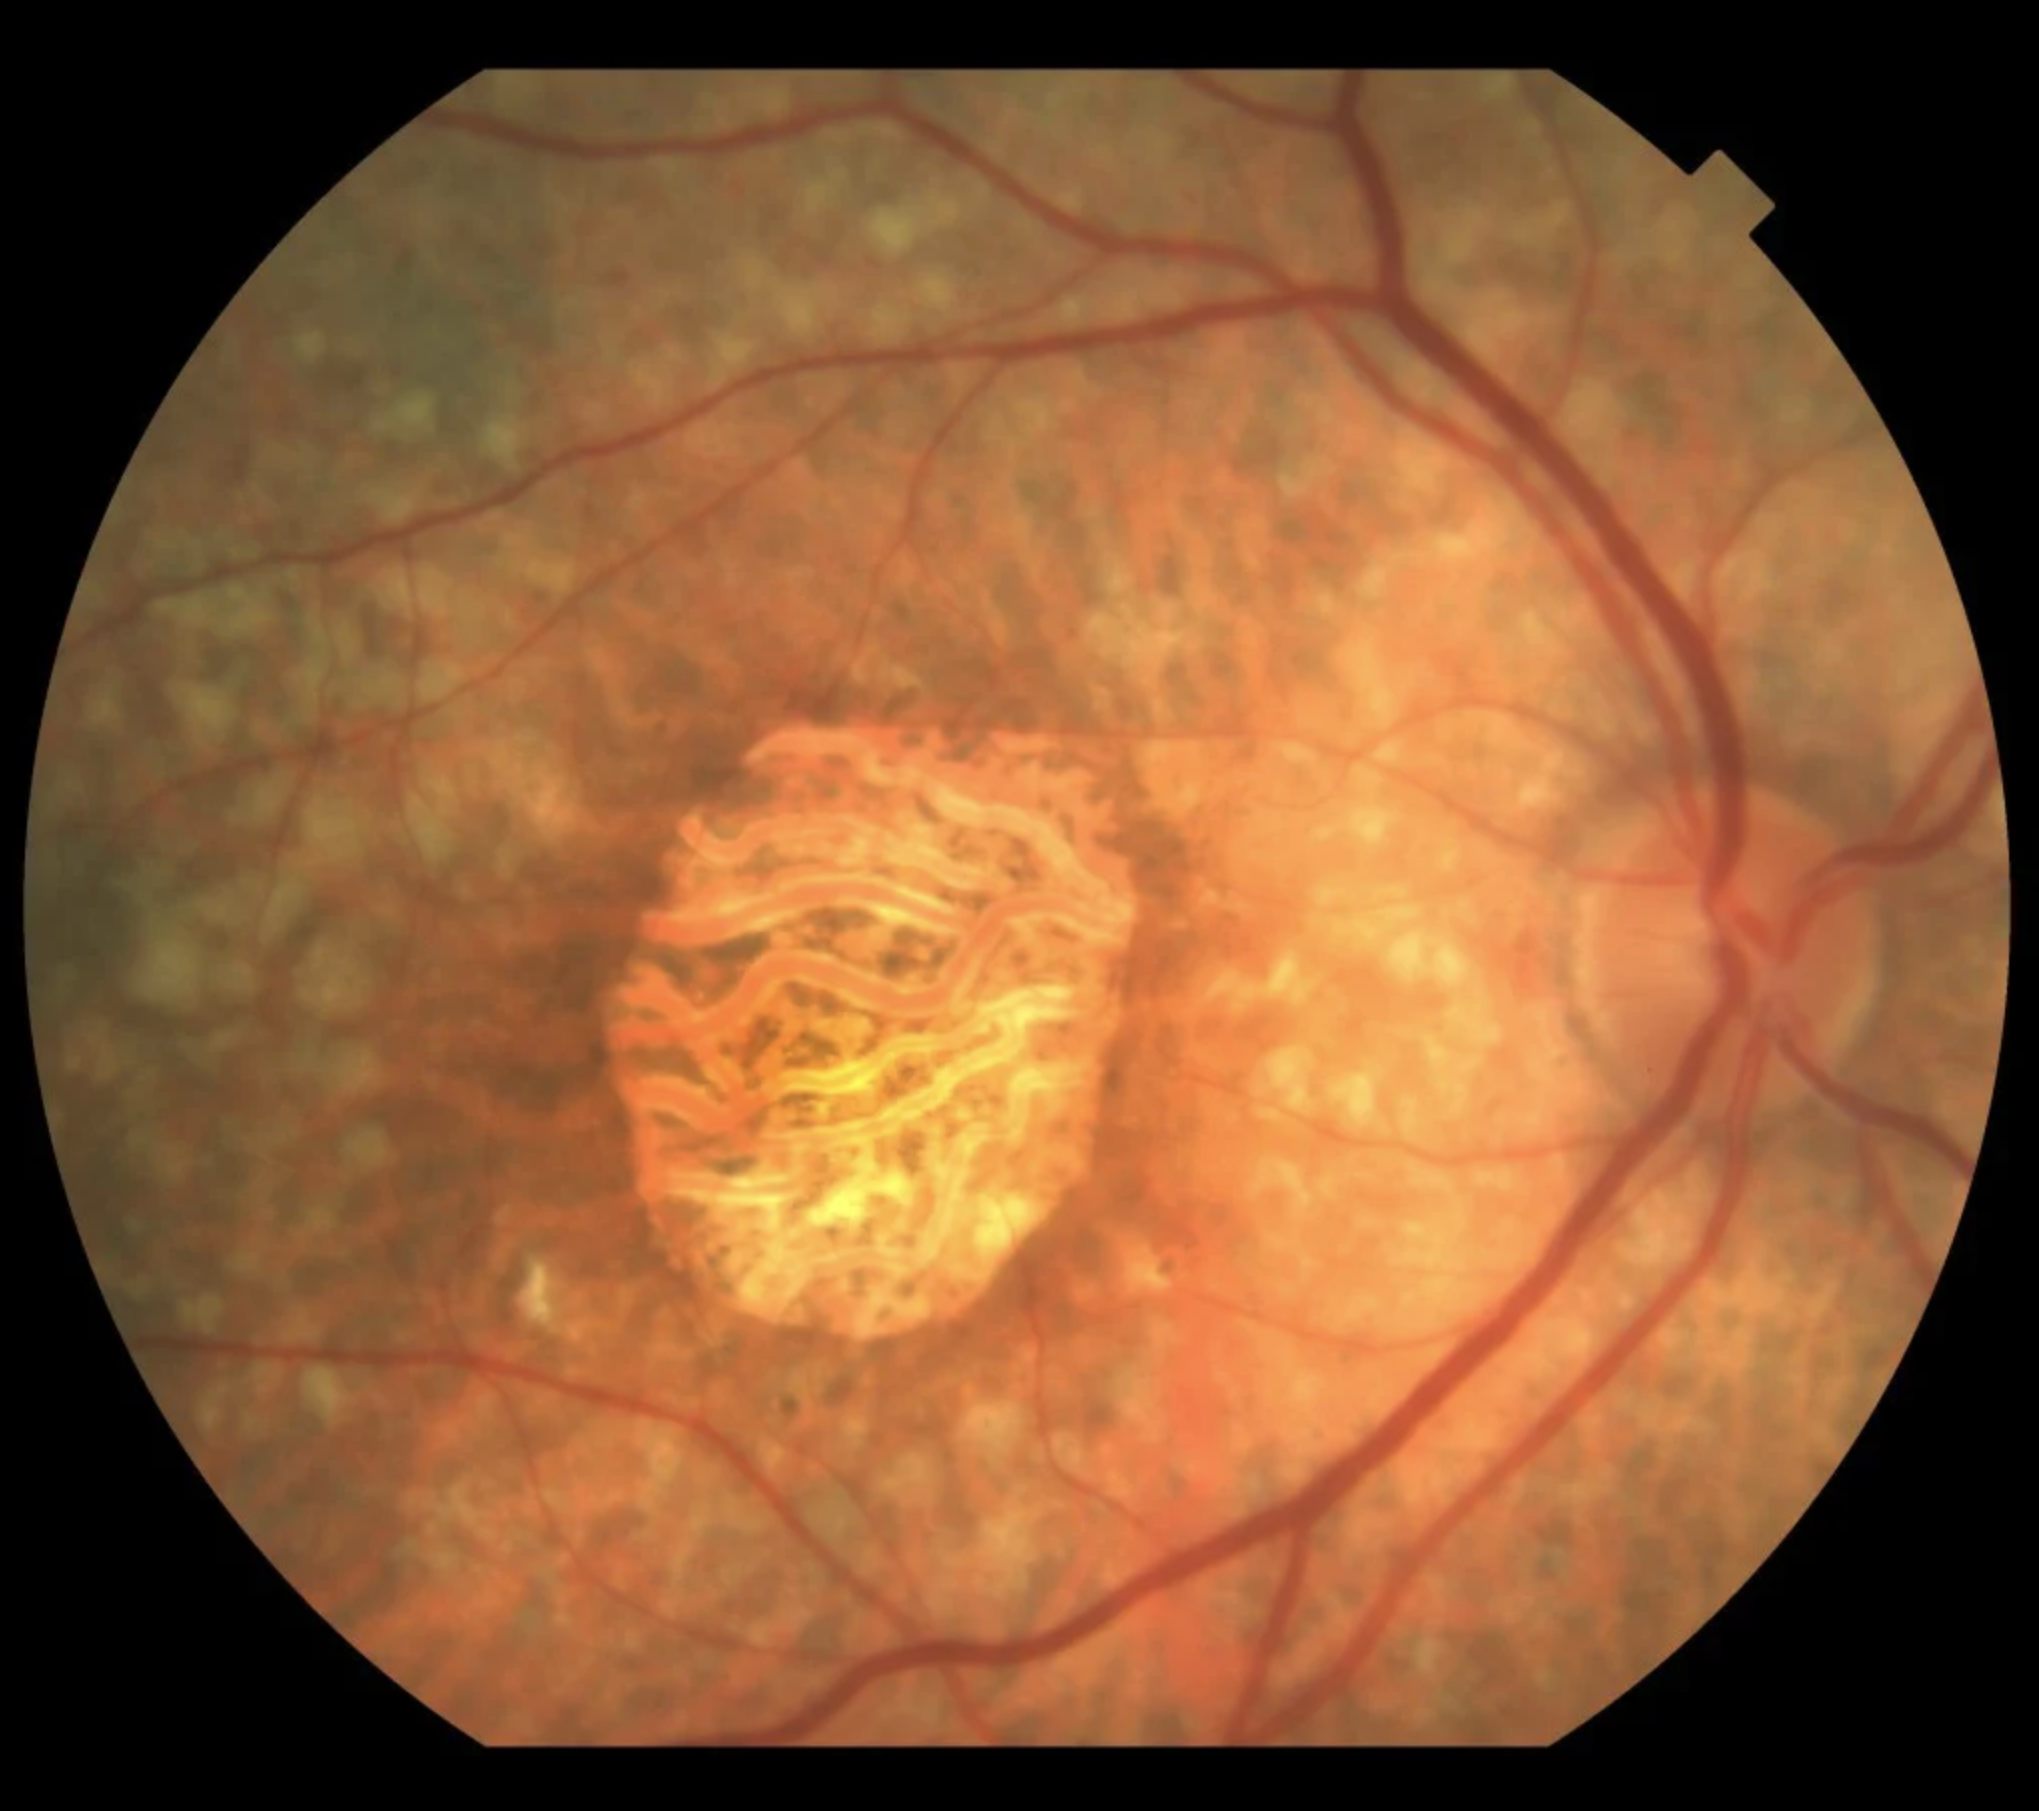

In [19]:
raw_image

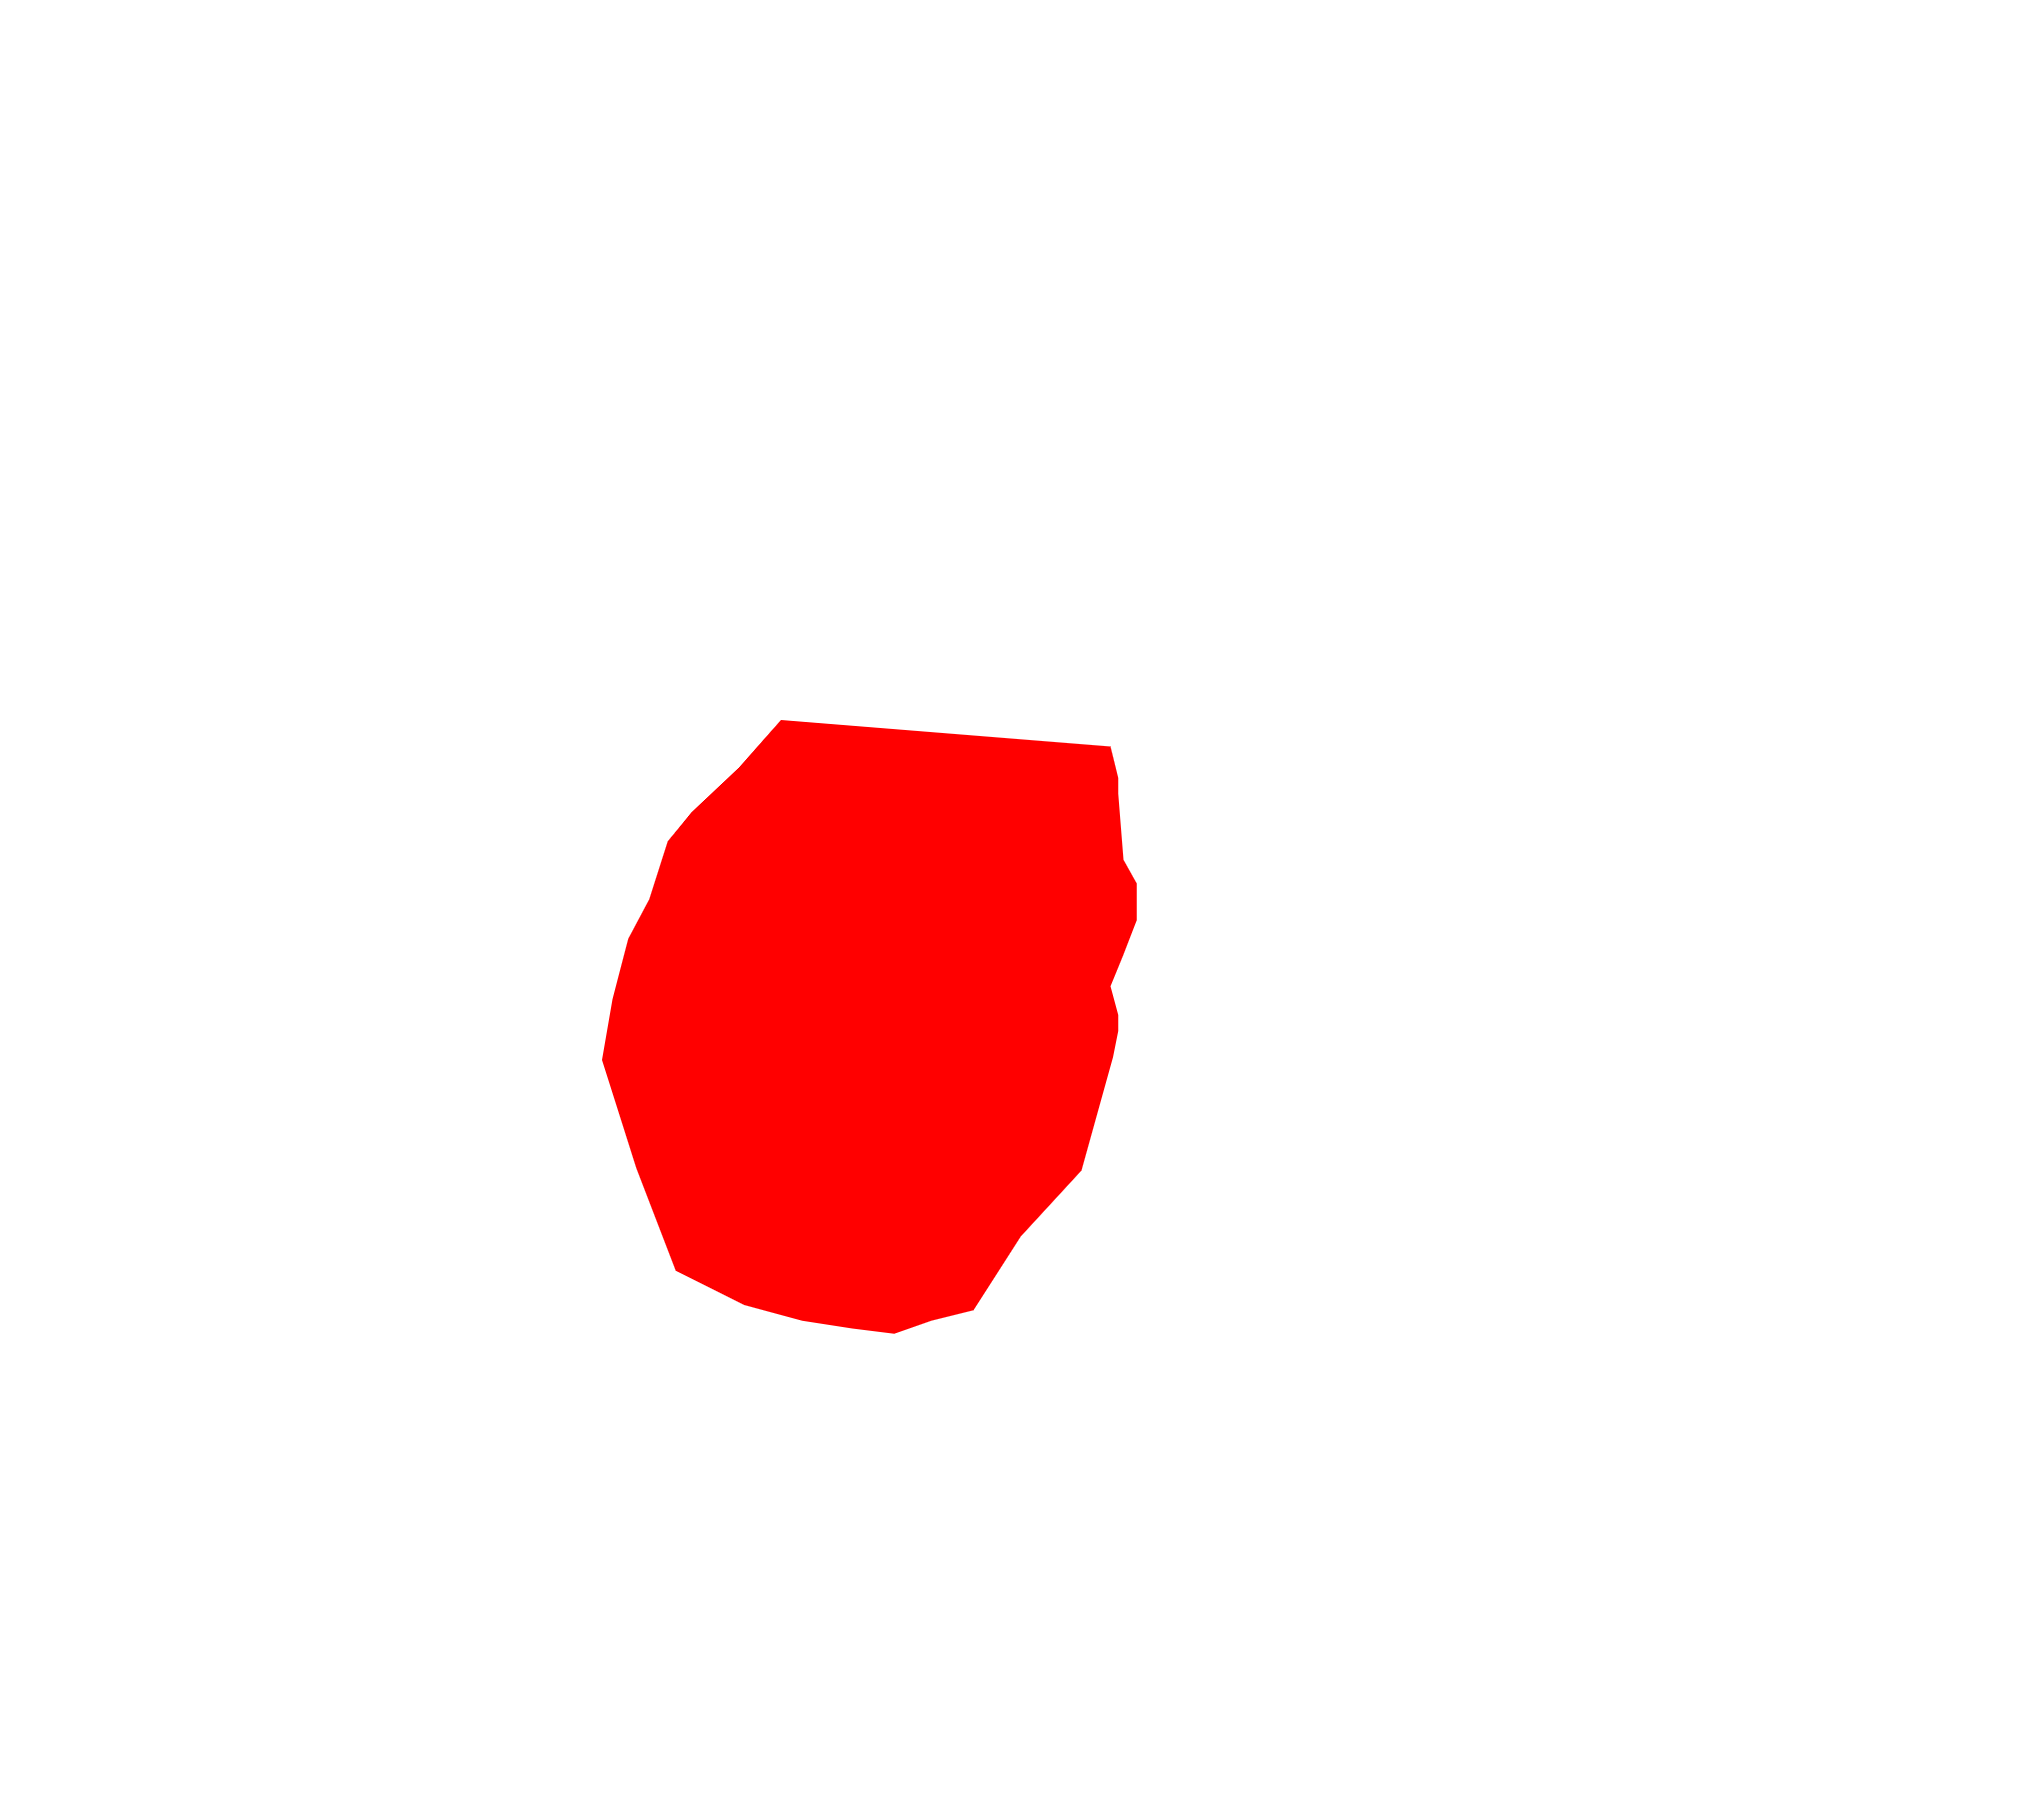

In [20]:
label

In [21]:
print(type(raw_image))
print(type(label))
print(np.array(raw_image).shape)
print(np.array(label).shape)

<class 'PIL.Image.Image'>
<class 'PIL.PngImagePlugin.PngImageFile'>
(1811, 2039, 3)
(1811, 2039, 4)


In [22]:
print((np.array(label)[:,:,0] == 0).all()) # R
print((np.array(label)[:,:,1] == 0).all()) # G
print((np.array(label)[:,:,2] == 0).all()) # B
print((np.array(label)[:,:,3] == 0).all()) # A

False
True
True
False


In [23]:
np.array(label)[800:900,800:900,0] # R

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [24]:
w = np.array(label).shape[0]
h = np.array(label).shape[1]
ground_truth_seg = np.array(label)[:,:,0].reshape(w, h)
ground_truth_seg_norm = ground_truth_seg / 255
print(f"{w} {h}")

1811 2039


1811 2039


(-0.5, 2038.5, 1810.5, -0.5)

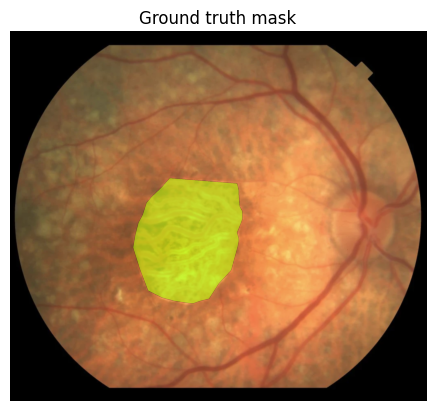

In [57]:
fig, axes = plt.subplots()

axes.imshow(np.array(raw_image))
show_mask(ground_truth_seg_norm, axes, random_color=True)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [115]:
class SAMDataset(Dataset):
    def __init__(self, dataset, processor):
        if isinstance(dataset, str):
            self.dataset = pd.read_csv(os.path.join(dataset))
        else:
            self.dataset = dataset
        self.processor = processor


    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if isinstance(self.dataset, pd.DataFrame):
            item = self.dataset.iloc[idx]
            image = item['image_path_orig']
            label = item['labels']
            image = monai.transforms.LoadImage(image_only=True)(os.path.join(DATA_DIR,image)) # (w, h, c)
            label = monai.transforms.LoadImage(image_only=True)(os.path.join(DATA_DIR,label)) # (w, h, c)
            image = monai.transforms.EnsureChannelFirst()(image) # (c, w, h) ... (0,1,2) to (2,1,0)
            label = monai.transforms.EnsureChannelFirst()(label) # (c, w, h) ... (0,1,2) to (2,1,0)
            # they come in as X-RAY type image with dimensions as (c, w, h)
            # basically we need (c, h, w) and we are making that happen
            image = torch.permute(image, (0,2,1)) # (c, h, w) ... new (0,1,2) to (0,2,1)
            image = image[0:3] # Grabbing R,G,B channels. Use pytorch as this is hacky
            label = torch.permute(label, (0,2,1)) # (c, h, w) ... new (0,1,2) to (0,2,1)
            label = label[0]
            # pdb.set_trace()
        else:            
            item = self.dataset[idx]
            image = item["image"]
            label = np.array(item["label"])

        # get bounding box prompt
        print(image.shape)
        print(label.shape)
        prompt = get_bounding_box(label)

        # prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # add ground truth segmentation
        inputs["label"] = label

        return inputs

### Create Pytorch Dataset

In [94]:
data_path = os.path.join(DATA_DIR, "image_key.csv")
our_data = pd.read_csv(data_path)
our_data.head()

,image_path_orig,labels,modality_maybe
0,Autofluorescence/DRY_AMD_FOVEAL_SPARING2.png,labels/DRY_AMD_FOVEAL_SPARING2.png,autofluorescence
1,Autofluorescence/DRY_FOVEAL_SPARING.png,labels/DRY_FOVEAL_SPARING.png,autofluorescence
2,Autofluorescence/Fundus_autofluorescence_GA.png,labels/Fundus_autofluorescence_GA.png,autofluorescence
3,Autofluorescence/more_GA.png,labels/more_GA.png,autofluorescence
4,Autofluorescence/some_GA.png,labels/some_GA.png,autofluorescence


In [109]:
SamProcessor()(input)

transformers.models.sam.processing_sam.SamProcessor

In [90]:
data_path

'/sddata/data/MedSAM/public_test_data_01_10_2023/image_key.csv'

In [116]:
dataset_ours = SAMDataset(data_path, processor)

In [122]:
image_ = dataset_ours[0]['pixel_values']
label_ = dataset_ours[0]['label']

torch.Size([3, 1665, 1657])
torch.Size([1665, 1657])
torch.Size([3, 1665, 1657])
torch.Size([1665, 1657])


In [124]:
dataset_ours[0]['original_sizes']

torch.Size([3, 1665, 1657])
torch.Size([1665, 1657])


tensor([1665, 1657])

### Create Pytorch DataLoader

### Train The Model